# Setup

Pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.2/112.6 GB disk)


In [2]:
# Kết nối với google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Predict with 1 image

YOLOv8 may be used directly in the Command Line Interface (CLI) with a `yolo` command for a variety of tasks and modes and accepts additional arguments, i.e. `imgsz=640`. See a full list of available `yolo` [arguments](https://docs.ultralytics.com/usage/cfg/) and other details in the [YOLOv8 Predict Docs](https://docs.ultralytics.com/modes/train/).


In [3]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/zidane.jpg'

100% 6.25M/6.25M [00:00<00:00, 114MB/s]
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100% 49.2k/49.2k [00:00<00:00, 7.61MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 83.3ms
Speed: 15.2ms preprocess, 83.3ms inference, 1043.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


# 2. Load Data.

In [4]:
!unrar x /content/drive/MyDrive/YOLO/coco128.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/YOLO/coco128.rar

Creating    coco128                                                   OK
Creating    coco128/coco128                                           OK
Creating    coco128/coco128/images                                    OK
Creating    coco128/coco128/images/train2017                          OK
Extracting  coco128/coco128/images/train2017/0000_00532_b.jpg              0%  OK 
Extracting  coco128/coco128/images/train2017/0000_02187_b.jpg              0%  OK 
Extracting  coco128/coco128/images/train2017/0000_05696_b.jpg              0%  OK 
Extracting  coco128/coco128/images/train2017/0000_06886_b.jpg              0%  OK 
Extracting  coco128/coco128/images/train2017/0000_08244_b.jpg              0%  OK 
Extracting  coco128/coco128/images/train2017/0001_05318_b.jpg              0%  OK 
Extracting  coco128/coc

In [18]:
import os
import cv2
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa dữ liệu
image_folder = '/content/coco128/coco128/images/train2017'
annotation_folder = '/content/coco128/coco128/labels/train2017'

# Lấy danh sách các tệp ảnh và nhãn
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
annotation_files = [f for f in os.listdir(annotation_folder) if f.endswith('.txt')]  # Giả sử nhãn là .json

# Đếm số lượng tệp ảnh và nhãn
num_images = len(image_files)
num_annotations = len(annotation_files)

print(f"Số lượng ảnh: {num_images}")
print(f"Số lượng nhãn: {num_annotations}")

Số lượng ảnh: 701
Số lượng nhãn: 701


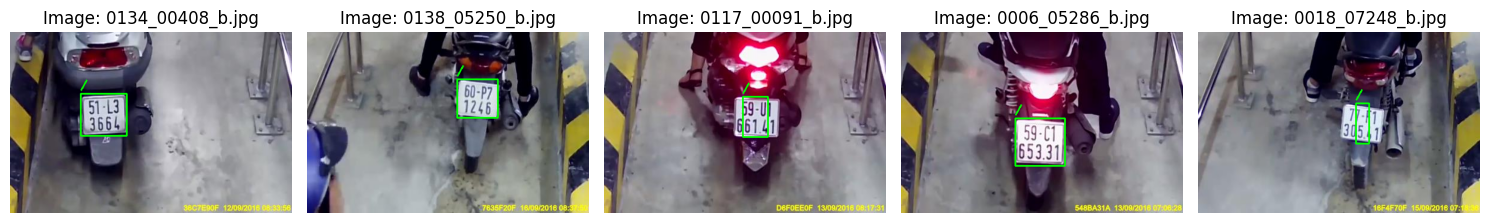

In [20]:

def load_yolo_labels(label_path):
    """
    Load YOLO labels from a .txt file.
    Args:
        label_path: Path to the label file.
    Returns:
        List of bounding boxes and class indices.
    """
    with open(label_path, 'r') as f:
        labels = f.readlines()
    boxes = []
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

def draw_boxes(image, boxes, class_names, color=(0, 255, 0), thickness=2):
    """
    Draw bounding boxes on an image.
    Args:
        image: The image to draw on.
        boxes: List of bounding boxes [(class_id, x_center, y_center, width, height), ...].
        class_names: List of class names.
    """
    height, width, _ = image.shape
    for box in boxes:
        class_id, x_center, y_center, w, h = box
        x1 = int((x_center - w / 2) * width)
        y1 = int((y_center - h / 2) * height)
        x2 = int((x_center + w / 2) * width)
        y2 = int((y_center + h / 2) * height)

        # Draw rectangle and class name
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
        class_name = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

def display_images(data_path, class_names, num_images=5):
    """
    Display images with bounding boxes from the YOLO dataset in a horizontal layout.
    Args:
        data_path: Path to the dataset folder containing 'images' and 'labels' subfolders.
        class_names: List of class names corresponding to the dataset.
        num_images: Number of images to display.
    """
    image_folder = os.path.join(data_path, 'images/train2017')
    label_folder = os.path.join(data_path, 'labels/train2017')

    # List all images
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')][:num_images]

    # Set up the figure with horizontal layout
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Adjust width (15) and height (5) for horizontal layout
    if num_images == 1:
        axes = [axes]  # Make sure axes is iterable if only 1 image is displayed

    for i, image_path in enumerate(image_paths):
        # Load image
        image = cv2.imread(image_path)
        image_name = os.path.basename(image_path)

        # Load corresponding labels
        label_path = os.path.join(label_folder, image_name.replace('.jpg', '.txt'))
        if os.path.exists(label_path):
            boxes = load_yolo_labels(label_path)
            draw_boxes(image, boxes, class_names)

        # Convert BGR to RGB for matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display image in the current subplot
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
        axes[i].set_title(f"Image: {image_name}")

    plt.tight_layout()
    plt.show()

data_path = '/content/coco128/coco128/'
class_names ='/content/coco128/coco128/'

display_images(data_path, class_names, num_images=5)


# 3. Train model yolov8
Epoch:  30

Image size: 640

In [11]:
# Train YOLOv8n on COCO8 for 30 epochs
!yolo train model=yolov8n.pt data=/content/drive/MyDrive/YOLO/coco128.yaml epochs=30 imgsz=640

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/YOLO/coco128.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

In [7]:
# Tải thư viện
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 22.6 MB/s eta 0:00:00


# 4. Predict with test set

In [23]:
import cv2
import numpy as np
import easyocr
import re
from ultralytics import YOLO
import glob  # Để xử lý danh sách tệp ảnh
from google.colab.patches import cv2_imshow

class ANPRWithoutButton:
    def __init__(self):
        self.reader = easyocr.Reader(['en'])
        self.text = ""
        self.frame = None
        self.model = YOLO(r"/content/runs/detect/train/weights/best.pt")  # Load the YOLO model

    def load_image(self, file_path):
        self.frame = cv2.imread(file_path)

    def process_frame(self):
        frame = self.frame  # Use the saved frame
        if frame is not None:
            results = self.model.predict(source=frame)

            for result in results:
                boxes = result.boxes.xyxy  # Bounding box coordinates (x1, y1, x2, y2)
                confidences = result.boxes.conf  # Confidence scores

                for box, confidence in zip(boxes, confidences):
                    if confidence > 0.25:  # Ensure the detection is confident enough
                        x1, y1, x2, y2 = map(int, box)

                        # Crop the detected license plate area
                        cropped_plate = frame[y1:y2, x1:x2]

                        # Use EasyOCR to read text from the cropped license plate
                        text_results = self.reader.readtext(cropped_plate)

                        # Extract and print the detected text
                        if text_results:
                            combined_text = " ".join([res[1] for res in text_results])
                            self.text = re.sub(r'[^A-Z0-9]', '', combined_text.upper())
                            formatted_text = self.format_license(self.text)
                            print("Biển số xe:", formatted_text)

                            # Draw the bounding box and text on the image
                            font = cv2.FONT_HERSHEY_SIMPLEX
                            text_size = cv2.getTextSize(formatted_text, font, 1, 2)[0]
                            text_x = int((x1 + x2 - text_size[0]) / 2)
                            text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
                            frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
                            frame = cv2.putText(frame, formatted_text, (text_x, text_y), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

            self.frame = frame

    def save_image(self, file_path):
        if self.frame is not None:
            cv2.imwrite(file_path, self.frame)

    def show_image(self):
        if self.frame is not None:
            cv2_imshow(self.frame)  # Thay thế cv2.imshow

    def format_license(self, text):
        if len(text) == 7:
            text += ' '  # Add space if the length of text is 7

        if len(text) < 8:
            return ""

        license_plate_ = ''
        dict_char_to_int = {'O': '0', 'I': '1', 'J': '3', 'A': '4', 'G': '6', 'S': '5', 'L': '4'}
        dict_int_to_char = {'0': 'O', '1': 'I', '3': 'J', '4': 'A', '6': 'G', '5': 'S', '8': 'B'}

        mapping = {0: dict_char_to_int, 1: dict_char_to_int, 2: dict_int_to_char, 3: dict_char_to_int, 4: dict_char_to_int,
                   5: dict_char_to_int, 6: dict_char_to_int, 7: dict_char_to_int, 8: dict_char_to_int}
        for j in range(min(len(text), 9)):
            if text[j] in mapping[j].keys():
                license_plate_ += mapping[j][text[j]]
            else:
                license_plate_ += text[j]

        return license_plate_

anpr = ANPRWithoutButton()

# Load and process multiple images
image_folder = '/content/coco128/coco128/images/Test'  # Đường dẫn tới thư mục chứa ảnh
output_folder = '/content/Output'  # Đường dẫn lưu ảnh đã xử lý

# Lấy danh sách 10 file ảnh trong thư mục test
image_paths = glob.glob(f"{image_folder}/*.jpg")[:10]

for idx, file_path in enumerate(image_paths):
    anpr.load_image(file_path)
    anpr.process_frame()

    # Hiển thị ảnh đã xử lý
    print(f"Displaying processed image {idx + 1}/{len(image_paths)}...")
    anpr.show_image()

    # Lưu ảnh đã xử lý với tên mới
    save_path = f"{output_folder}/processed_image_{idx + 1}.jpg"
    anpr.save_image(save_path)
    print(f"Processed and saved: {save_path}")

print("Processing completed for 10 images.")


Output hidden; open in https://colab.research.google.com to view.